In [1]:
import h5py
import numpy as np
import datetime
from loss import calculate_loss
from models.N2N_Unet import N2N_Unet_DAS, N2N_Orig_Unet, Cut2Self, U_Net_origi, U_Net, TestNet
from utils import add_noise_snr

import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import os
import glob
import sys
import time
from pathlib import Path

In [2]:
class DASDataset(Dataset):
    def __init__(self, root_dir):
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.h5'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as f_in:
            DAS_data = f_in['DAS'][:]
            #tmp = file_path.split('/')[-1].split('.h5')[0].split('_')[3:5]
            tmp = file_path.split('\\')[-1].split('.h5')[0].split('_')[3:5]
            #start_datetime = datetime.datetime.strptime(tmp[0] + ' ' + tmp[1], '%Y%m%d %H%M%S.%f')
            start_datetime = [float(i) for i in tmp]
        return DAS_data, start_datetime

# Pfad zum Wurzelverzeichnis Ihrer Daten
root_dir = 'Server_DAS/eq_data_50Hz'

# Erstellen des Datasets
das_dataset = DASDataset(root_dir)

# Erstellen des DataLoaders
batch_size = 1  # oder eine andere gewünschte Batchgröße
dataloader = DataLoader(das_dataset, batch_size=batch_size, shuffle=False)

#data, _ = next(iter(dataloader))


In [3]:
#data.shape

In [4]:
methoden_liste = ["n2noise", "n2score", "n2self", "n2self j-invariant", "n2same", "n2same batch", "n2void"]
#"n2self", "n2self j-invariant" haben problleme mit 1 chanel
device = "cuda" if torch.cuda.is_available() else "cpu"
data, _ = next(iter(dataloader))
print(data.shape)
model = TestNet(1,1).to(device)
sigma = 2
augmentation = True
batch_idx = 0
dropout_rate = 0.3
lambda_inv = 2
original = (data.unsqueeze(1).to(device))[:, :, :300, :748] #macht aus (b, w, h)  (b,1,w,h)
noise_images, alpha = add_noise_snr(original, snr_db=sigma)
noise_images = noise_images.to(device)
for methode in methoden_liste:
    print(methode)
    loss, denoised, original, noise_images, optional_tuples = calculate_loss(model, device, dataloader, methode, sigma, batch_idx, original, noise_images, augmentation, lambda_inv=lambda_inv, dropout_rate=dropout_rate)
    print(loss)

torch.Size([1, 3000, 7488])
n2noise
tensor(549689.5000, device='cuda:0', grad_fn=<MseLossBackward0>)
n2score
tensor(2371.0283, device='cuda:0', grad_fn=<MeanBackward0>)
n2self
tensor(66858.6250, device='cuda:0', grad_fn=<MseLossBackward0>)
n2self j-invariant
tensor(66858.6250, device='cuda:0', grad_fn=<MseLossBackward0>)
n2same
tensor(1.2164, device='cuda:0', grad_fn=<AddBackward0>)
n2same batch
tensor(1.3087, device='cuda:0', grad_fn=<AddBackward0>)
n2void
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


Index(['Wall time', 'Step', 'Value'], dtype='object')


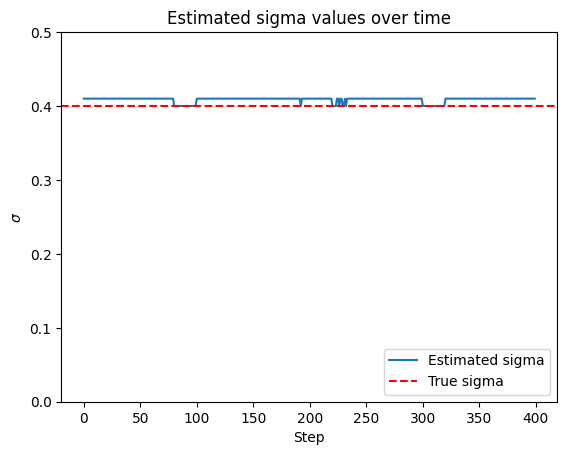

In [4]:
import pandas as pd
import numpy as np

# Pfad zur CSV-Datei
csv_file_path = 'scoreSigma.csv'

# Lade die CSV-Datei mit pandas
df = pd.read_csv(csv_file_path)

# Angenommen, die Spalte, die du extrahieren möchtest, heißt 'desired_column'
# Wenn du den Spaltennamen nicht kennst, kannst du ihn dir mit df.columns anzeigen lassen
print(df.columns)

# Extrahiere die gewünschte Spalte und konvertiere sie in ein NumPy-Array
column_name = 'Value'
y = df[column_name].to_numpy()

# Optional: Drucke das NumPy-Array, um es zu überprüfen
x = np.arange(len(y))

# Plotten der Daten
plt.plot(x, y, label="Estimated sigma")

# Horizontale Linie bei y = 0.4 hinzufügen
plt.axhline(y=0.4, color='r', linestyle='--', label='True sigma')

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel('Step')
plt.ylabel("$\sigma$")
plt.title('Estimated sigma values over time')

plt.ylim(0, 0.5)

# Legende hinzufügen
plt.legend(loc='lower right')

# Plot anzeigen
plt.show()